In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import joblib  # Modeli kaydetmek için
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
#from sklearn.svm import SVR
#from sklearn.metrics import mean_absolute_error, r2_score, max_error

In [3]:
df = pd.read_csv('BeijingPM20100101_20151231.csv')

In [4]:
df

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


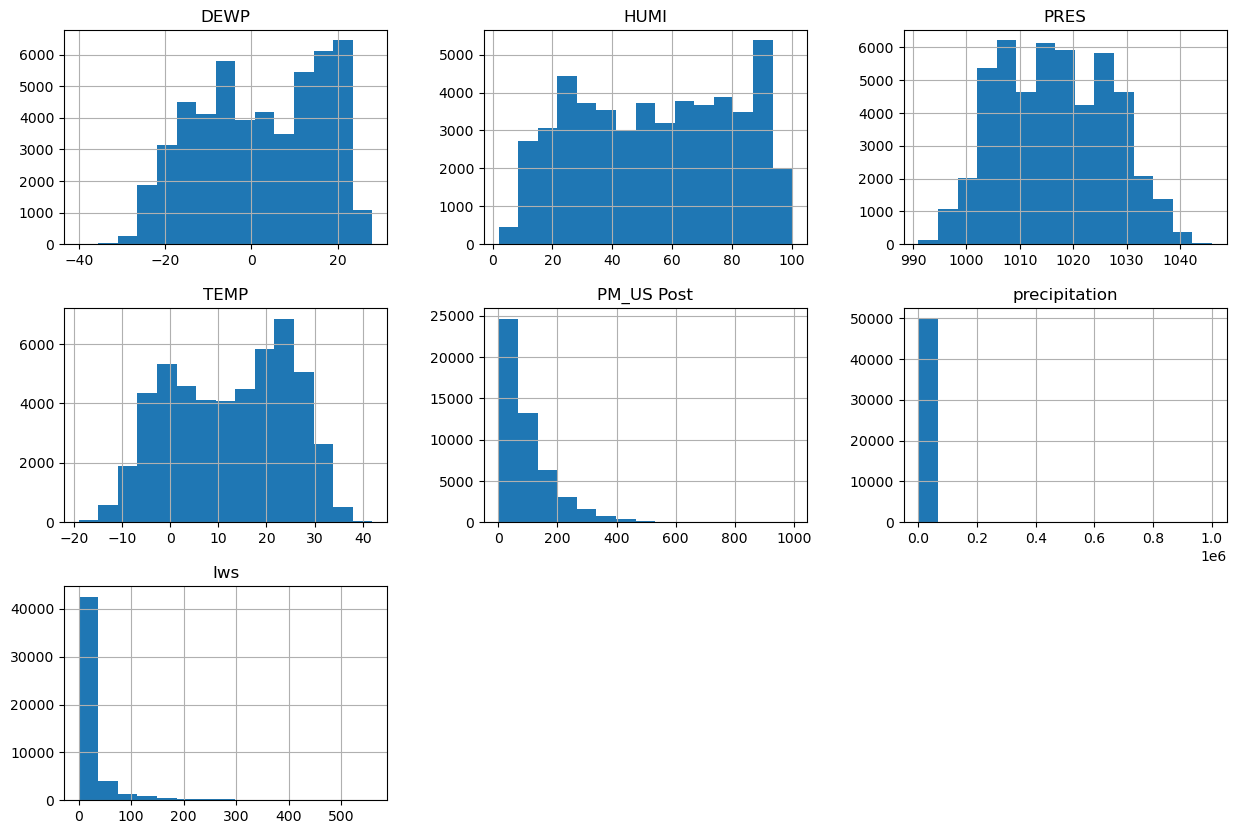

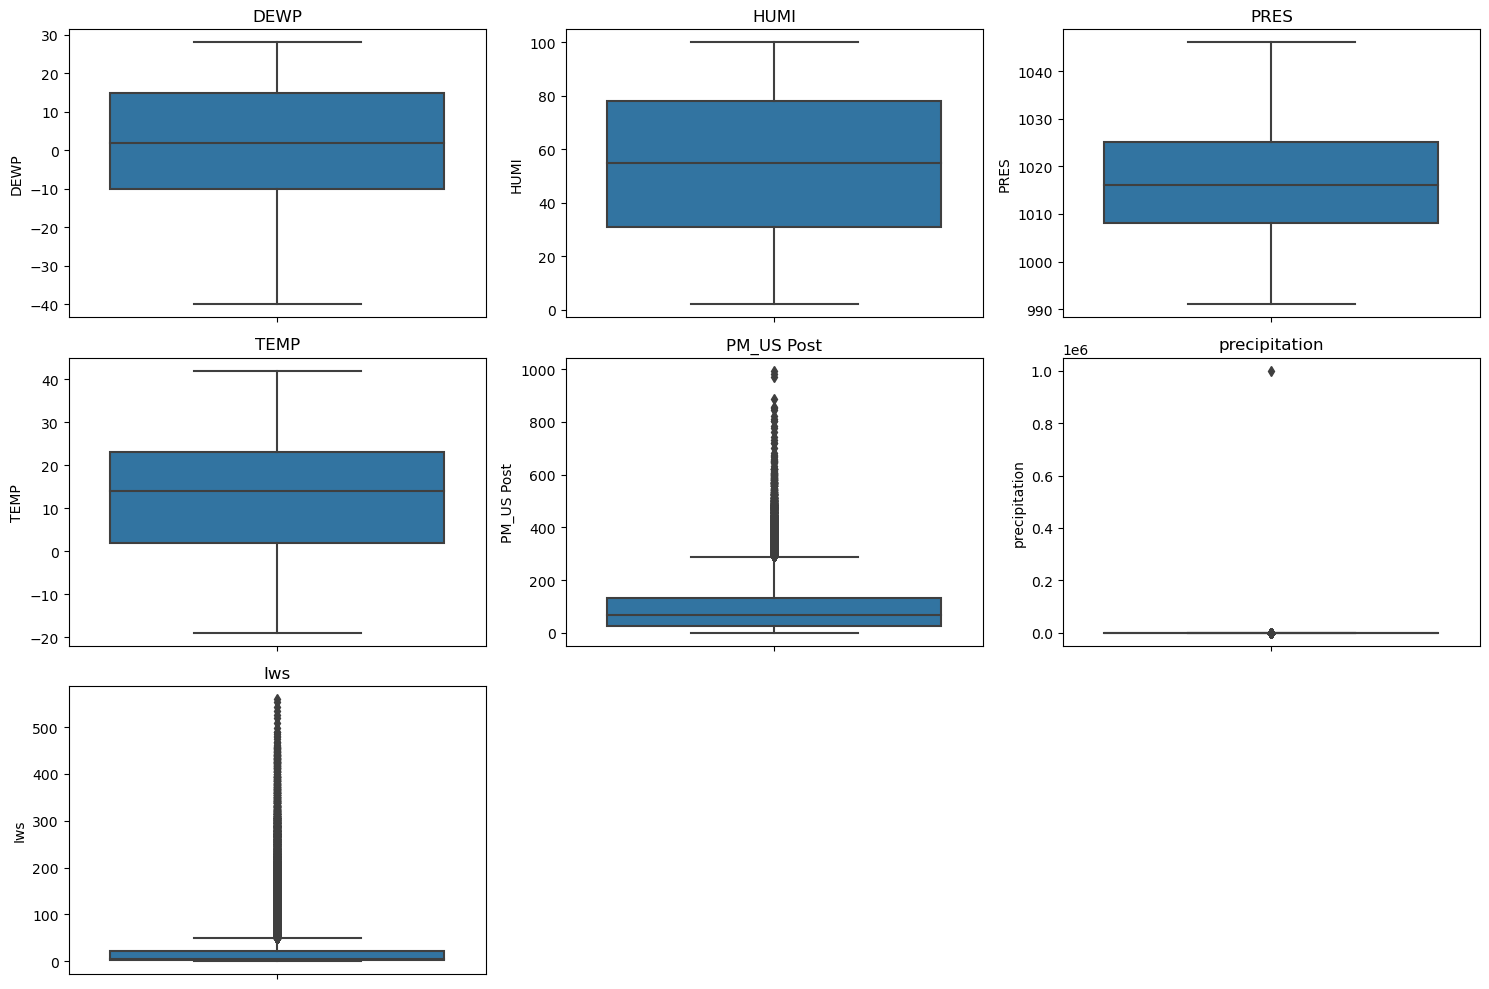

<Figure size 1500x1000 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cleaned = df.dropna(subset=['PM_US Post'])

# Selecting the same subset of columns for analysis
columns_to_analyze = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'PM_US Post','precipitation','Iws']

# Plotting histograms for selected columns

df_cleaned[columns_to_analyze].hist(bins=15, figsize=(15, 10), layout=(3, 3))

plt.figure(figsize=(15, 10))  # Boyutları, tüm alt grafiklerin sığması için genişlettim
for i, col in enumerate(columns_to_analyze):
    plt.subplot(3, 3, i + 1)  # subplot indexi 1'den başlar
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()  # Grafikleri düzgün bir şekilde sığdırmak için
plt.show()
plt.figure(figsize=(15, 10))  # Boyutları, tüm alt grafiklerin sığması için genişlettim


plt.tight_layout()
plt.show()

In [6]:
# 'precipitation' değişkeni için sıfır değerlerini gösteren yeni bir ikili özellik
# 'precipitation' değeri 0 ise yeni değişken 1, değilse 0 değerini alır
df['No_Precipitation'] = (df['precipitation'] == 0).astype(int)

In [7]:
df['Air_Quality'] = ['clean' if x <= 25 else 'dirty' for x in df['PM_US Post']]

# 'Air_Quality' sütununu hedef değişken olarak kullanarak modelinizi eğitmek için hazırlayın
X = df.drop(['PM_US Post', 'Air_Quality'], axis=1)  # Özellik matrisi, hedef ve etiket sütunları hariç
y = df['Air_Quality']

In [8]:
# 'Air_Quality' sütununda her bir sınıfın dağılımını hesapla
class_distribution = df['Air_Quality'].value_counts()

# Sınıf dağılımını yazdır
print(class_distribution)


Air_Quality
dirty    40848
clean    11736
Name: count, dtype: int64


In [9]:
# pmusporttaki eksik değerli sütunların cıkarılması
df = df.dropna(subset=['PM_US Post']) 

In [10]:
# sayısal sütunların belirlenmesi
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [11]:
# eksik değerlerin sayısal sütunlarda doldurulması
for col in numerical_cols:
    df.loc[:, col] = df.loc[:, col].fillna(df[col].mean())

In [12]:
# eksik değerleri unknown ile doldurma ve label encoding uygulama
df.loc[:, 'cbwd'] = df['cbwd'].fillna('Unknown')
label_encoder = LabelEncoder()
df.loc[:, 'cbwd'] = label_encoder.fit_transform(df['cbwd'])


In [13]:
df

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,No_Precipitation,Air_Quality
23,24,2010,1,1,23,4,89.155484,92.442068,88.515875,129.0,-17.0,41.0,1020.0,-5.0,4,0.89,0.0,0.0,1,dirty
24,25,2010,1,2,0,4,89.155484,92.442068,88.515875,148.0,-16.0,38.0,1020.0,-4.0,2,1.79,0.0,0.0,1,dirty
25,26,2010,1,2,1,4,89.155484,92.442068,88.515875,159.0,-15.0,42.0,1020.0,-4.0,2,2.68,0.0,0.0,1,dirty
26,27,2010,1,2,2,4,89.155484,92.442068,88.515875,181.0,-11.0,63.5,1021.0,-5.0,2,3.57,0.0,0.0,1,dirty
27,28,2010,1,2,3,4,89.155484,92.442068,88.515875,138.0,-7.0,85.0,1022.0,-5.0,2,5.36,0.0,0.0,1,dirty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.000000,157.000000,122.000000,133.0,-8.0,68.0,1031.0,-3.0,2,7.14,0.0,0.0,1,dirty
52580,52581,2015,12,31,20,4,157.000000,199.000000,149.000000,169.0,-8.0,63.0,1030.0,-2.0,2,8.03,0.0,0.0,1,dirty
52581,52582,2015,12,31,21,4,171.000000,231.000000,196.000000,203.0,-10.0,73.0,1030.0,-6.0,0,0.89,0.0,0.0,1,dirty
52582,52583,2015,12,31,22,4,204.000000,242.000000,221.000000,212.0,-10.0,73.0,1030.0,-6.0,0,1.78,0.0,0.0,1,dirty


In [14]:
df['cbwd'].head()

23    4
24    2
25    2
26    2
27    2
Name: cbwd, dtype: object

In [15]:
# Özellik ve hedef değişkenlerini ayırma
X = df[['TEMP', 'PRES', 'DEWP', 'HUMI', 'cbwd','hour','season','month','No_Precipitation']]  # Bağımsız değişkenler

In [16]:
y = df['Air_Quality']  # Hedef değişken

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [35]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [36]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       clean       0.70      0.48      0.57      2366
       dirty       0.86      0.94      0.89      7712

    accuracy                           0.83     10078
   macro avg       0.78      0.71      0.73     10078
weighted avg       0.82      0.83      0.82     10078



In [37]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen Kappa Score: {kappa}")

Cohen Kappa Score: 0.468821058393843


In [38]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8293312165112126


In [39]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [40]:
print(f"Accuracy: {accuracy}")
print(class_report)

Accuracy: 0.8412383409406629
              precision    recall  f1-score   support

       clean       0.66      0.68      0.67      2366
       dirty       0.90      0.89      0.90      7712

    accuracy                           0.84     10078
   macro avg       0.78      0.78      0.78     10078
weighted avg       0.84      0.84      0.84     10078



In [41]:
joblib.dump(model, 'air_quality_classifier.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [42]:
# Modeli kaydetme
joblib.dump(model, 'air_quality_classifier.joblib')
joblib.dump(scaler, 'scaler.joblib')
model = joblib.load('air_quality_classifier.joblib')
scaler = joblib.load('scaler.joblib')

In [43]:
new_data = {
    'TEMP': [56],
    'PRES': [13],  
    'DEWP': [1020], 
    'HUMI': [24], 
    'cbwd': [14],  
    'hour': [3], 
    'season': [4],
    'month': [12],
    'No_Precipitation': [1]
}


In [44]:
new_data_df = pd.DataFrame(new_data)

In [45]:
new_data_scaled = scaler.transform(new_data_df)

In [46]:
prediction = model.predict(new_data_scaled)

In [47]:
print(f"The Air Quality prediction is: {prediction[0]}")

The Air Quality prediction is: dirty


In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
cm = confusion_matrix(y_test, y_pred)

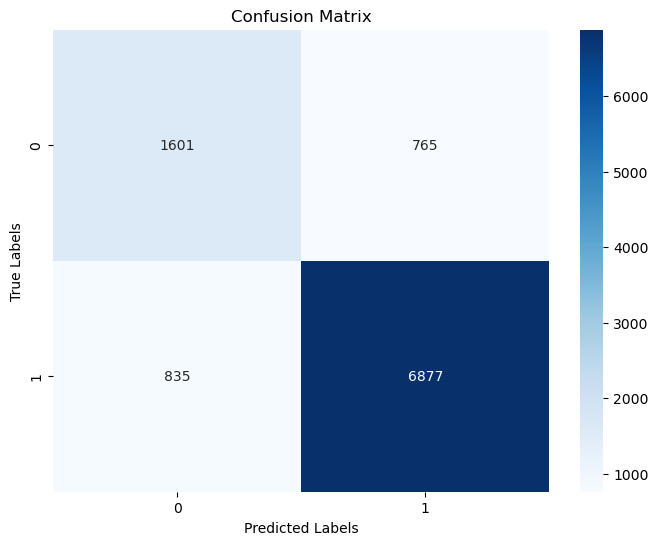

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [51]:
precision = precision_score(y_test, y_pred, pos_label='dirty')
recall = recall_score(y_test, y_pred, pos_label='dirty')

In [52]:
print(f'Precision (Kesinlik): {precision:.2f}')
print(f'Recall (Duyarlılık): {recall:.2f}')

Precision (Kesinlik): 0.90
Recall (Duyarlılık): 0.89


In [53]:
precision = precision_score(y_test, y_pred, pos_label='clean')
recall = recall_score(y_test, y_pred, pos_label='clean')

In [54]:
print(f'Precision (Kesinlik): {precision:.2f}')
print(f'Recall (Duyarlılık): {recall:.2f}')

Precision (Kesinlik): 0.66
Recall (Duyarlılık): 0.68


In [55]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
mean_cv_scores = cv_scores.mean()
std_cv_scores = cv_scores.std()

In [56]:
print(f'CV Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {mean_cv_scores:.4f}')
print(f'Standard Deviation of CV Accuracy: {std_cv_scores:.4f}')

CV Accuracy Scores: [0.84659655 0.84024608 0.8597797  0.83040587 0.81939069]
Mean CV Accuracy: 0.8393
Standard Deviation of CV Accuracy: 0.0138


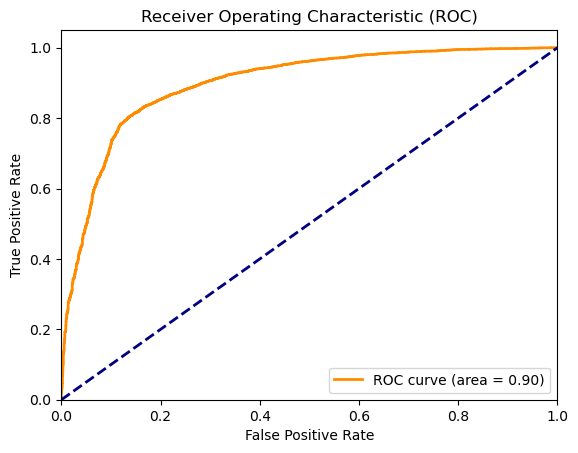

In [57]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Veri setini ve etiketleri hazırlayın
# X, y = ...

# Eğitim ve test setlerine ayırın
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluşturun ve eğitin
svm_model = SVC(probability=True)  # Olasılık tahminleri için probability=True olarak ayarlanmalı
svm_model.fit(X_train, y_train)

# Test setindeki tahmin olasılıklarını alın
y_score = svm_model.predict_proba(X_test)[:, 1]

# Gerçek etiketleri ikili formata dönüştürün
y_test_bin = label_binarize(y_test, classes=['clean', 'dirty'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)


# ROC eğrisi için true positive rate (TPR) ve false positive rate (FPR) hesaplayın
fpr, tpr, _ = roc_curve(y_test_bin, y_score)

# AUC değerini hesaplayın
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirin
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

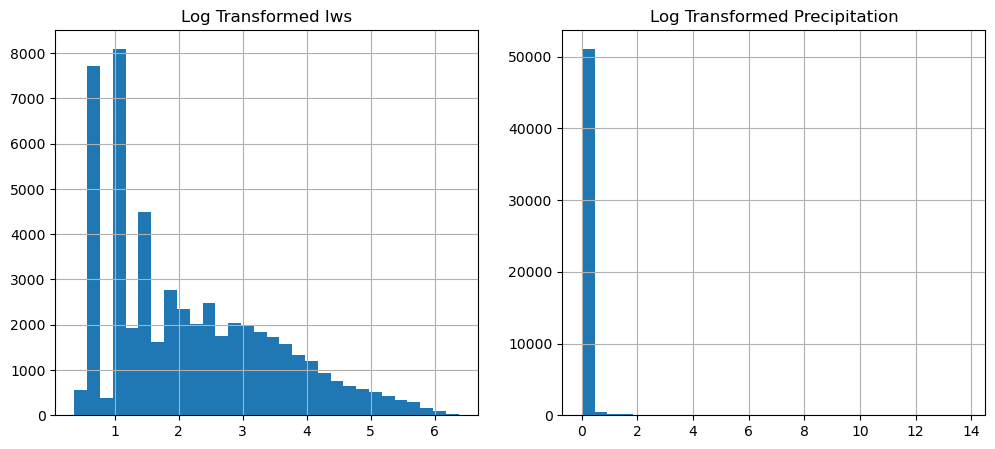

In [3]:

df = pd.read_csv('BeijingPM20100101_20151231.csv')

df.loc[:, 'Iws_log'] = np.log1p(df['Iws'])
df.loc[:, 'precipitation_log'] = np.log1p(df['precipitation'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df['Iws_log'].hist(ax=ax[0], bins=30)
ax[0].set_title('Log Transformed Iws')
df['precipitation_log'].hist(ax=ax[1], bins=30)
ax[1].set_title('Log Transformed Precipitation')
plt.show()